In [2]:
import time
import random
import pickle
import math
import scipy as sp
import scipy.stats as sps

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
start = time.time()
# ======================================
# Modeling
class SequenceModel(nn.Module):
    def __init__(self, input_size=1796, output_dim=1796, hidden_size=256, num_layers=1):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.scaler_bias = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.scaler = nn.Parameter(torch.ones(input_size, requires_grad=True))
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        x = (x + self.scaler_bias) * self.scaler
        zs, hidden = self.lstm(x)
        z = zs[:, -1]
        v = self.linear(zs)
        return v, z

In [4]:
model = SequenceModel(input_size=1578,
                      output_dim=1578,
                      hidden_size=128,
                      num_layers=1)

In [5]:
model.load_state_dict(torch.load( "ckpt/model.ckpt"))
model.eval()

SequenceModel(
  (lstm): LSTM(1578, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1578, bias=True)
)

In [6]:
with open("./ckpt/Z.pickle", "rb") as f:
    Z = pickle.load(f)
    
with open("./ckpt/scaler.pickle", "rb") as f:
    scaler = pickle.load(f)
    
with open("./ckpt/multi_pdf.pickle", "rb") as f:
    multi_pdf = pickle.load(f)
    
    mean_vector = multi_pdf['mean_vector']
    covariance_inv = multi_pdf['covariance_inv']
    
    covariance = multi_pdf['covariance']
    covariance_det = multi_pdf['covariance_det']


In [7]:
# Prepare Data
def make_batch(data, batch_size, window_size, shuffle=True):
    window_list = []
    for i in range(len(data) - window_size - 1):
        window = data[i: i + window_size]
        window_list.append(window)

    if shuffle:
        random.shuffle(window_list)

    n_batch = math.ceil(len(window_list) / batch_size)
    batch_list = []
    for i in range(n_batch):
        batch = window_list[i*batch_size: (i+1)*batch_size]
        batch_list.append(batch)
    batch_list = np.array(batch_list)

    return batch_list

In [8]:
var = sps.multivariate_normal(mean=mean_vector, cov=covariance)
    

In [24]:
########### anomaly detection #################
#1) put the newdata into the model

newdata = pd.read_csv("1s_15s_stress.csv", sep=',', index_col=False)
#newdata = pd.read_csv("2.recurrent_MEM_1023.csv", sep=',', index_col=False)
#newdata = pd.read_csv("./test.csv", sep=',', index_col=False)
forhead = pd.read_csv("./all_metric_sort_err.csv", sep=',', index_col=False)
headers = [h for h in newdata.keys() if not h.startswith('container_') and not h.startswith("go_") and not h.startswith("node_filesystem_") and h in forhead.keys()]
newdata = newdata[headers]
#dataframe = pd.DataFrame(newdata.keys())
#dataframe.to_csv("./ckpt/test_header_current.csv", header=False, index=False)
newdata.shape
newdata = newdata.to_numpy()
newdata = scaler.transform(newdata)


In [40]:


Z_newdata = []
window_size = 10
batch_size =192

reconstruction_error_new =[]
v_diff_list = []
anormal_score_list = []

for i in range(len(newdata) - window_size - 1):
    batch_input = newdata[i: i + window_size]
    batch_input = torch.tensor(batch_input, dtype=torch.float32).unsqueeze(0)
    new_v, new_z = model(batch_input)
    Z_newdata.append(new_z.detach().numpy())
    
    n_feature = new_v.shape[2]

    v_pred = new_v[:, :-1, :]  # 1 x (window_size-1) x n_feature
    
    v_gt = batch_input[:, 1:, :]
    
    v_diff = torch.abs(v_gt - v_pred) # 1 x (window_size-1) x n_feature
        
    v_diff = v_diff.mean(dim=1)  # 1 x n_feature
    
    # v_diff = torch.clamp(v_diff, -10, 10)
    
    v_diff = v_diff.detach().cpu().numpy()
    
    v_diff_list.append(v_diff)
    
    anormal_score = np.matmul(np.matmul((v_diff - mean_vector), covariance_inv), (v_diff - mean_vector).transpose())   # (1 x feature_dim) x (feature_dim x feature_dim) x (feature_dim x 1) 
    anormal_score = anormal_score.flatten()[0]
    # prob =  (1./ (np.power((2*np.pi), n_feature/2. ) *  np.power(covariance_det, 1./2. ) )) * np.exp( (-1./2.)*anormal_score)
    
    # anormal_score_list.append(anormal_score)
    
    # prob = sps.multivariate_normal.pdf(v_diff.flatten(), mean=mean_vector, cov=covariance)
    reconstruction_error_new.append(anormal_score)
print("time :", time.time() - start)


time : 241.79210114479065


In [53]:
max_val = 6.712601104463904e+31

min_val = min(reconstruction_error_new)

reconstruction_error_new = (reconstruction_error_new-min_val) / (max_val-min_val)

min_val = min(reconstruction_error_new)
max_val = max(reconstruction_error_new)

gradient = (min_val**min_val) +(max_val**max_val)

#threshold = max_val

In [54]:
gradient

2.0

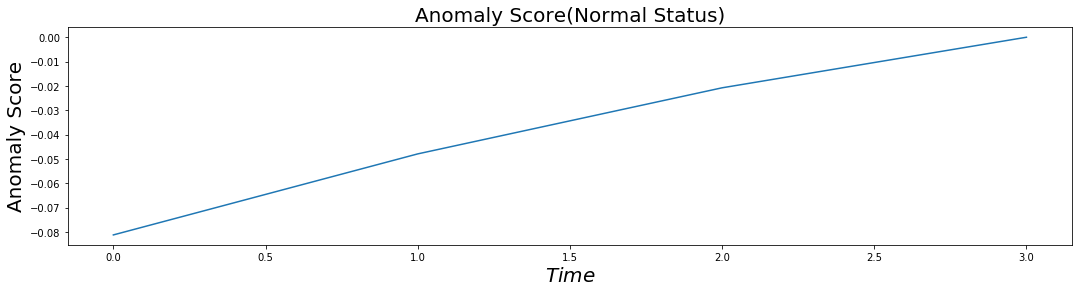

In [48]:
plt.figure(figsize=(18,4))
plt.plot(range(len(reconstruction_error_new)), reconstruction_error_new)

plt.title("Anomaly Score(Normal Status)", fontsize=20)

#plt.title("Anomaly Score with CPU Usage", fontsize=20)
plt.xlabel("$Time$", fontsize=20)
plt.ylabel("Anomaly Score", fontsize=20)
#plt.yscale('log')
plt.show()
dataframe = pd.DataFrame(reconstruction_error_new)
dataframe.to_csv("./ckpt/test.csv", header=False, index=False)

In [49]:
monitor = pd.read_csv("./1.figure_cpu.csv", sep=',', index_col=False)
#monitor = pd.read_csv("./2.figure_mem.csv", sep=',', index_col=False)
#monitor = pd.read_csv("./3.figure_network.csv", sep=',', index_col=False)
#monitor = pd.read_csv("./test_one.csv", sep=',', index_col=False)
#3.figure_network_test
monitor = monitor.to_numpy()
monitor.shape
x = len(monitor)

# 

In [45]:
mean_anormal = np.array(reconstruction_error_new).mean()
std_anormal =  np.array(reconstruction_error_new).std()

mean_monitor = np.array(monitor).mean()
std_monitor =  np.array(monitor).std()

No handles with labels found to put in legend.


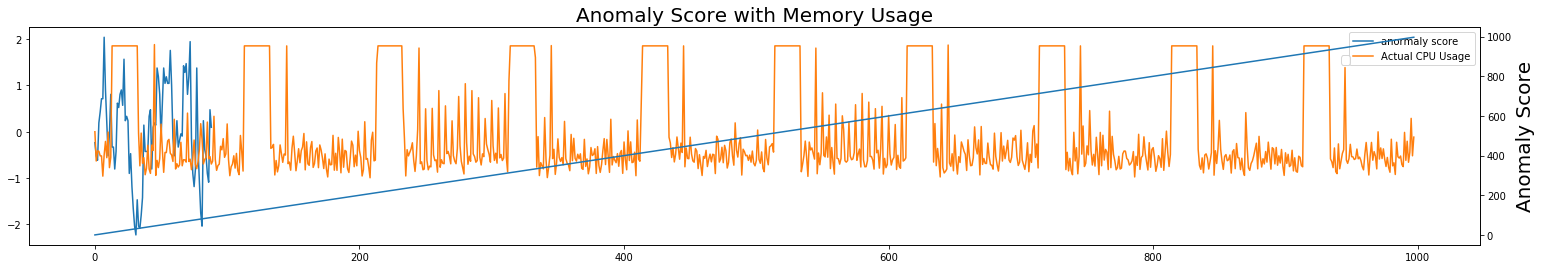

In [16]:
plt.figure(figsize=(26,4))
plt.plot(range(len(reconstruction_error_new)), (np.array(reconstruction_error_new) - mean_anormal)/std_anormal, label="anormaly score")
plt.plot(range(len(monitor)), (monitor-mean_monitor)/std_monitor, label="Actual CPU Usage")
plt.legend()
ax1 = plt.gca()
ax2 = plt.gca()
#ax.axes.yaxis.set_visible(False)

plt.title("Anomaly Score with Memory Usage", fontsize=20)
ax2 = ax1.twinx()
ax2.plot(range(len(monitor)),)

plt.xlabel("$Time$", fontsize=20)
plt.ylabel("Anomaly Score", fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(0.9, 0.9), fontsize='large')

plt.show()
dataframe = pd.DataFrame(reconstruction_error_new)
dataframe.to_csv("./ckpt/test1.csv", header=False, index=False)

In [17]:
range(len(monitor))

range(0, 998)

In [18]:
range(len(reconstruction_error_new))

range(0, 89)